In [1]:
##########
# These are the essential libraries and model functions

import numpy as np
import pylab as pl
from numba import jit
import random
from matplotlib import colors

# Time step of the numerical simulation
dt = 0.01


@jit  # We use python-numba to speed up the process
def first_order_lowpass_filter(signal_in, signal_out, tau, dt):
    """Applies a simple RC circuit lowpass filter to a signal.
    :param signal_in: Input signal (will be read)
    :param signal_out: Output signal (will be filled)
    :param tau: Time constant of the low-pass filter
    :param dt: Time delta of the signal
    """
    
    alpha_lowpass = dt / (tau + dt)

    signal_out[0] = signal_in[0]

    for i in range(1, len(signal_in)):
        signal_out[i] = alpha_lowpass*signal_in[i] + \
                        (1 - alpha_lowpass) * signal_out[i-1]


@jit  # We use python-numba to speed up the process
def simulate_network(is_embedded_fish,
             turn_off_stimulus_after_first_bout,
             ts,
             Is_left, xs_left, ys_left, zs_left, ms_left,
             Is_right, xs_right, ys_right, zs_right, ms_right,
             bout_times, bout_decisions):
    """
    :param is_embedded_fish: In embedded fish bout clock will be zero
    :param turn_off_stimulus_after_first_bout: Closed-loop?
    :param ts: Buffer of times
    :param Is_left: Buffer for times of left stimulation (just bias)
    :param xs_left: Buffer for left red cluster (integrator)
    :param ys_left: Buffer for left cyan cluster (high-pass) 
    :param zs_left: Buffer for left integrator read-out element
    :param ms_left: Buffer for left motor elements (magenta)
    :param Is_right: Buffer for times of right stimulation (just bias)
    :param xs_right: Buffer for right red cluster (integrator)
    :param ys_right: Buffer for right cyan cluster (high-pass) 
    :param zs_right: Buffer for right integrator read-out element
    :param ms_right: Buffer for right motor elements (magenta)
    :param bout_times: Buffer for bout times
    :param bout_decisions: Buffer for bout directions
    :return: bout_conter
    """
        
    # See Figure 5a for illustration of elements
    
    # X: This is the red cluster, which integrates signals
    # Y: This is the cyan cluster, which acts as a high-pass filter
    # Z: This is a helper cluster which reads out the sate of the red cluster
    # M: This is the magenta cluster, which inititates motor events
    
    # The free parameter of the model are the time constants
    tau_x = 12  # Slow for the integrator
    tau_y = 1.5 # Fast
    tau_z = 0.5 # Fast
    tau_m = 0.5 # Fast
    
    # In the embedded fish, the bout block is turned off
    if is_embedded_fish:
        bout_clock_probability = 0
    else:
        bout_clock_probability = 0.015
    
    # Initialize states
    ts[0] = 0
    
    xs_left[0] = 0
    ys_left[0] = 0
    zs_left[0] = 0
    ms_left[0] = 0
    
    xs_right[0] = 0
    ys_right[0] = 0
    zs_right[0] = 0
    ms_right[0] = 0

    bout_counter = 0

    # Loop over time (Forward euler)
    for i in range(1, len(ts)):

        ts[i] = ts[i - 1] + dt

        # Turn stimulus off after the first bout during the stimulus?
        if turn_off_stimulus_after_first_bout:
            
            # Only turn it off, when the bout happened after stimulus onset
            # We ignore bouts which happen before
            if bout_counter > 0 and bout_times[bout_counter-1] > 40:
                Is_left[i] = 0
                Is_right[i] = 0

        # Is the spontaneous bout clock active? 
        # This will shunt both cyan clusters
        if random.random() < bout_clock_probability:
            cyan_shunt = 30
        else:
            cyan_shunt = 0

        # The noise has a large variance and its mean is positive
        random_left = random.gauss(0.4, 3)
        random_right = random.gauss(0.4, 3)
        
        # This implements the network wiring according to Figure 5a
        # Synaptic are free parameters (Z -> Y: w = -1.47), (Z -> X: w= -0.5)
        # Every other connection w = 1 or w = -1
        
        # Left hemisphere
        dx_left = -xs_left[i - 1] + Is_left[i - 1] + \
                  random_left - zs_left[i - 1] - 0.5 * zs_right[i - 1]
        
        dy_left = -ys_left[i - 1] + Is_left[i - 1] + \
                  random_left - 1.47*zs_left[i - 1] - cyan_shunt
        
        dz_left = -zs_left[i - 1] + xs_left[i - 1]
        
        # Right hemisphere
        dx_right = -xs_right[i - 1] + Is_right[i - 1] + \
                   random_right - zs_right[i - 1] - 0.5 * zs_left[i - 1]
        
        dy_right = -ys_right[i - 1] + Is_right[i - 1] + \
                   random_right - 1.47 * zs_right[i - 1] - cyan_shunt
        
        dz_right = -zs_right[i - 1] + xs_right[i - 1]
        
        # Will there be a motor pulse?
        
        # We initiate a motor pulse of the red cluster (X)
        # Is larger than the cyan cluster (+ some distance)
        # Motor events can only occur of both magenta clusters
        # are close to baseline, implementing some refractory period
        
        # Left hemisphere
        if xs_left[i-1] - ys_left[i-1] > 0.13 and \
                ms_left[i - 1] < 0.005 and ms_right[i - 1] < 0.005:
            dm_left = -ms_left[i - 1] + 1.5
        else:
            dm_left = -ms_left[i - 1]
        
        # Right hemisphere
        if xs_right[i-1] - ys_right[i-1] > 0.13 and \
                ms_left[i - 1] < 0.005 and ms_right[i - 1] < 0.005:
            dm_right = -ms_right[i - 1] + 1.5
        else:
            dm_right = -ms_right[i - 1]
            
        # Update the variables
        xs_left[i] = xs_left[i - 1] + dx_left * dt / tau_x
        ys_left[i] = ys_left[i - 1] + dy_left * dt / tau_y
        zs_left[i] = zs_left[i - 1] + dz_left * dt / tau_z
        ms_left[i] = ms_left[i - 1] + dm_left * dt / tau_m

        xs_right[i] = xs_right[i - 1] + dx_right * dt / tau_x
        ys_right[i] = ys_right[i - 1] + dy_right * dt / tau_y
        zs_right[i] = zs_right[i - 1] + dz_right * dt / tau_z
        ms_right[i] = ms_right[i - 1] + dm_right * dt / tau_m        

        # The rate of any neuron cannot be negative
        if xs_left[i] < 0:
            xs_left[i] = 0
        if ys_left[i] < 0:
            ys_left[i] = 0
        if zs_left[i] < 0:
            zs_left[i] = 0
        if ms_left[i] < 0:
            ms_left[i] = 0

        if xs_right[i] < 0:
            xs_right[i] = 0
        if ys_right[i] < 0:
            ys_right[i] = 0
        if zs_right[i] < 0:
            zs_right[i] = 0
        if ms_right[i] < 0:
            ms_right[i] = 0
        
        # The animal swims of either the left or the right magenta cluster 
        # got a pulse. This happened if either hemisphere 
        # had a cluster crossing of red and cyan clusters
        if dm_left > 0 or dm_right > 0:
            
            bout_times[bout_counter] = ts[i]
            
            bout_decisions[bout_counter] = \
                -1 if xs_right[i] - xs_left[i] < 0 else 1

            bout_counter += 1

    return bout_counter

In [2]:
##########
# We now run the stimulation for the constant stimulation
# This should reproduce Figure 5b

# Create empty lists to store the trial data for the 3 testes coherence values
xs_left_when_left = [[], [], []]
ys_left_when_left = [[], [], []]
ms_left_when_left = [[], [], []]

xs_left_when_right = [[], [], []]
ys_left_when_right = [[], [], []]
ms_left_when_right = [[], [], []]

xs_right_when_left = [[], [], []]
ys_right_when_left = [[], [], []]
ms_right_when_left = [[], [], []]

xs_right_when_right = [[], [], []]
ys_right_when_right = [[], [], []]
ms_right_when_right = [[], [], []]

xs_bout_triggered = [[], [], []]
ys_bout_triggered = [[], [], []]
ms_bout_triggered = [[], [], []]

# The time is longer than the on in the experiment
# to reduce border effects of the modelling 
ts = np.arange(0, 120, dt)

# Buffers for the simulation
xs_left = np.empty_like(ts)
ys_left = np.empty_like(ts)
zs_left = np.empty_like(ts)
ms_left = np.empty_like(ts)

xs_right = np.empty_like(ts)
ys_right = np.empty_like(ts)
zs_right = np.empty_like(ts)
ms_right = np.empty_like(ts)

bout_times = np.empty(10000)
bout_decisions = np.empty(10000)
            
for stim in range(3):
                
    for direction in [-1, 1]:
        for trial in range(1000):
            
            # Stimulus buffers
            Is_right = np.zeros_like(ts)
            Is_left = np.zeros_like(ts)
            
            ind = np.where((ts > 40) & (ts < 80))
            
            coherence = [25, 50, 100][stim]
            
            if direction < 0:
                Is_left[ind] += coherence / 100 * 0.2
                Is_right[ind] -= 0.4 * coherence / 100 * 0.2
            else:
                Is_left[ind] -= 0.4 * coherence / 100 * 0.2
                Is_right[ind] += coherence / 100 * 0.2

            bout_counter = simulate_network(
                True, False,  # Fish is embedded, and stimulus keeps going
                ts,
                Is_left, xs_left, ys_left, zs_left, ms_left,
                Is_right, xs_right, ys_right, zs_right, ms_right,
                bout_times, bout_decisions)

            # Apply a low-pass filter to roughly mimic calcium convolution
            first_order_lowpass_filter(xs_left, xs_left, 3, dt)
            first_order_lowpass_filter(ms_left, ms_left, 3, dt)
            first_order_lowpass_filter(ys_left, ys_left, 3, dt)

            first_order_lowpass_filter(xs_right, xs_right, 3, dt)
            first_order_lowpass_filter(ms_right, ms_right, 3, dt)
            first_order_lowpass_filter(ys_right, ys_right, 3, dt)
            
            # Subtract baseline
            xs_left -= xs_left[int(30 / dt):int(40 / dt)].mean()
            ys_left -= ys_left[int(30 / dt):int(40 / dt)].mean()
            ms_left -= ms_left[int(30 / dt):int(40 / dt)].mean()
            
            xs_right -= xs_right[int(30 / dt):int(40 / dt)].mean()
            ys_right -= ys_right[int(30 / dt):int(40 / dt)].mean()
            ms_right -= ms_right[int(30 / dt):int(40 / dt)].mean()

            if direction == -1:
                xs_left_when_left[stim].append(
                    xs_left[int(20 / dt):int(100 / dt)].copy())
                
                ys_left_when_left[stim].append(
                    ys_left[int(20 / dt):int(100 / dt)].copy())
                
                ms_left_when_left[stim].append(
                    ms_left[int(20 / dt):int(100 / dt)].copy())

                xs_right_when_left[stim].append(
                    xs_right[int(20 / dt):int(100 / dt)].copy())
                
                ys_right_when_left[stim].append(
                    ys_right[int(20 / dt):int(100 / dt)].copy())
                
                ms_right_when_left[stim].append(
                    ms_right[int(20 / dt):int(100 / dt)].copy())
            else:
                xs_left_when_right[stim].append(
                    xs_left[int(20 / dt):int(100 / dt)].copy())
                
                ys_left_when_right[stim].append(
                    ys_left[int(20 / dt):int(100 / dt)].copy())
                
                ms_left_when_right[stim].append(
                    ms_left[int(20 / dt):int(100 / dt)].copy())

                xs_right_when_right[stim].append(
                    xs_right[int(20 / dt):int(100 / dt)].copy())
                
                ys_right_when_right[stim].append(
                    ys_right[int(20 / dt):int(100 / dt)].copy())
                
                ms_right_when_right[stim].append(
                    ms_right[int(20 / dt):int(100 / dt)].copy())

# Average over trials
xs_left_when_left_avg = np.mean(xs_left_when_left, axis=1)
xs_left_when_right_avg = np.mean(xs_left_when_right, axis=1)

ys_left_when_left_avg = np.mean(ys_left_when_left, axis=1)
ys_left_when_right_avg = np.mean(ys_left_when_right, axis=1)

ms_left_when_left_avg = np.mean(ms_left_when_left, axis=1)
ms_left_when_right_avg = np.mean(ms_left_when_right, axis=1)

xs_right_when_left_avg = np.mean(xs_right_when_left, axis=1)
xs_right_when_right_avg = np.mean(xs_right_when_right, axis=1)

ys_right_when_left_avg = np.mean(ys_right_when_left, axis=1)
ys_right_when_right_avg = np.mean(ys_right_when_right, axis=1)

ms_right_when_left_avg = np.mean(ms_right_when_left, axis=1)
ms_right_when_right_avg = np.mean(ms_right_when_right, axis=1)

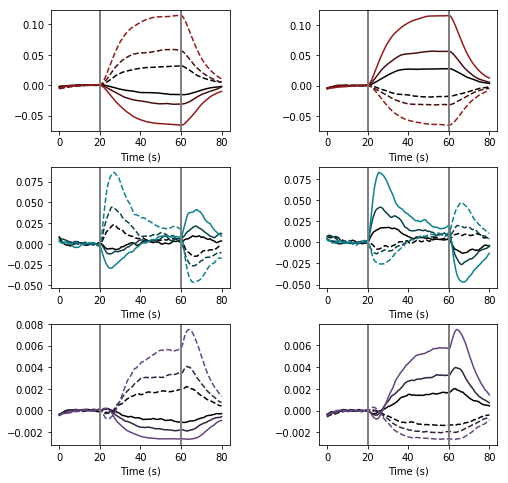

In [3]:
############
# Plot the cluster averages

pl.figure(figsize=(8,8))
grid = pl.GridSpec(3, 2, wspace=0.5, hspace=0.3)

def plot_responses(grid_x, grid_y, region_when_left, region_when_right, color):
    
    hsv_color = colors.rgb_to_hsv(colors.to_rgb(color))
    
    pl.subplot(grid[grid_x, grid_y])
    
    for stim in range(3):
    
        color_saturated = colors.hsv_to_rgb([hsv_color[0], 
                                             hsv_color[1] , 
                                             hsv_color[2] * stim / 3])
        
        pl.plot(ts[int(20 / dt):int(100 / dt)]-20, 
                region_when_left[stim], '--', color=color_saturated)
        
        pl.plot(ts[int(20 / dt):int(100 / dt)]-20, 
                region_when_right[stim], '-', color=color_saturated)
        
        pl.xlabel("Time (s)")
        pl.axvline(20, color='gray')
        pl.axvline(60, color='gray')
        

plot_responses(0, 0, xs_left_when_left_avg, xs_left_when_right_avg, "C3")
plot_responses(0, 1, xs_right_when_left_avg, xs_right_when_right_avg, "C3")

plot_responses(1, 0, ys_left_when_left_avg, ys_left_when_right_avg, "C9")
plot_responses(1, 1, ys_right_when_left_avg, ys_right_when_right_avg, "C9")

plot_responses(2, 0, ms_left_when_left_avg, ms_left_when_right_avg, "C4")
plot_responses(2, 1, ms_right_when_left_avg, ms_right_when_right_avg, "C4")
    
pl.show()

In [4]:
##########
# Calculate reliability index
reliability_index_x = [[], [], []]
reliability_index_y = [[], [], []]
reliability_index_m = [[], [], []]

for stim in range(3):
    data = np.hstack((xs_left_when_left[stim], xs_right_when_right[stim]))

    mean0 = np.nanmean(data, axis=0)
    std0 = np.nanstd(data, axis=0)

    reliability_index_x[stim] = \
        np.abs((mean0 / std0)[int(20 / dt):int(60 / dt)].mean())

    ####
    data = np.hstack((ys_left_when_left[stim], ys_right_when_right[stim]))

    mean0 = np.nanmean(data, axis=0)
    std0 = np.nanstd(data, axis=0)

    reliability_index_y[stim] = \
        np.abs((mean0 / std0)[int(20 / dt):int(60 / dt)].mean())

    ####
    data = np.hstack((ms_left_when_left[stim], ms_right_when_right[stim]))

    mean0 = np.nanmean(data, axis=0)
    std0 = np.nanstd(data, axis=0)

    reliability_index_m[stim] = \
        np.abs((mean0 / std0)[int(20 / 0.5):int(60 / 0.5)].mean())

# Averag over stims
reliability_index_x_avg = np.mean(reliability_index_x)
reliability_index_y_avg = np.mean(reliability_index_y)
reliability_index_m_avg = np.mean(reliability_index_m)

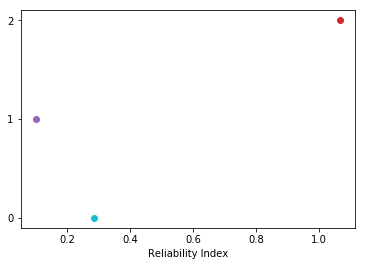

In [5]:
##########
# Plot the average reliability index of each of the units

pl.plot(reliability_index_x_avg, 2, 'o', color="C3")
pl.plot(reliability_index_y_avg, 0, 'o', color="C9")
pl.plot(reliability_index_m_avg, 1, 'o', color="C4")

pl.xlabel("Reliability Index")
pl.yticks([0, 1, 2])

pl.show()

In [6]:
##########
# We now perform closed-loop simulation, but only for one coherence
# This should reproduce Figure 5d

xs_bout_triggered = []
ys_bout_triggered = []
ms_bout_triggered = []

ts = np.arange(0, 120, dt)

# Create buffers for the simulation
xs_left = np.empty_like(ts)
ys_left = np.empty_like(ts)
zs_left = np.empty_like(ts)
ms_left = np.empty_like(ts)

xs_right = np.empty_like(ts)
ys_right = np.empty_like(ts)
zs_right = np.empty_like(ts)
ms_right = np.empty_like(ts)

bout_times = np.empty(10000)
bout_decisions = np.empty(10000)

for trial in range(1000):

    # Create the stimulus buffers
    Is_right = np.zeros_like(ts)
    Is_left = np.zeros_like(ts)

    ind = np.where((ts > 40) & (ts < 80))
    
    coherence = 25

    Is_left[ind] -= 0.4 * coherence / 100 * 0.2
    Is_right[ind] += coherence / 100 * 0.2

    bout_counter = simulate_network(
        True, True,  # Fish is embedded, and stimulus is turned off after bout
        ts,
        Is_left, xs_left, ys_left, zs_left, ms_left,
        Is_right, xs_right, ys_right, zs_right, ms_right,
        bout_times, bout_decisions)

    # Apply a low-pass filter to roughly mimic calcium convolution
    first_order_lowpass_filter(xs_left, xs_left, 3, dt)
    first_order_lowpass_filter(ms_left, ms_left, 3, dt)
    first_order_lowpass_filter(ys_left, ys_left, 3, dt)

    first_order_lowpass_filter(xs_right, xs_right, 3, dt)
    first_order_lowpass_filter(ms_right, ms_right, 3, dt)
    first_order_lowpass_filter(ys_right, ys_right, 3, dt)
    
    # Subtract baseline
    xs_left -= xs_left[int(30 / dt):int(40 / dt)].mean()
    ys_left -= ys_left[int(30 / dt):int(40 / dt)].mean()
    ms_left -= ms_left[int(30 / dt):int(40 / dt)].mean()

    xs_right -= xs_right[int(30 / dt):int(40 / dt)].mean()
    ys_right -= ys_right[int(30 / dt):int(40 / dt)].mean()
    ms_right -= ms_right[int(30 / dt):int(40 / dt)].mean()

    if bout_counter > 1:
        
        # We only consider bouts happening after stimulus start
        bouts_after_stim_ind = np.where(bout_times[:bout_counter] > 40)[0]
        
        if len(bouts_after_stim_ind) > 0:

            first_bout_i = bouts_after_stim_ind[0] # Pick the first bout
            first_bout_time = bout_times[:bout_counter][first_bout_i]
            first_bout_decision = bout_decisions[:bout_counter][first_bout_i]
            
            # Index in buffer data related to that bout
            i0 = np.where(ts > first_bout_time)[0][0]
            
            # Boundary problems?
            if i0 - int(10/dt) < 0 or i0 + int(10/dt) >= len(ts):
                continue
            
            # Only consider right bouts
            if first_bout_decision > 0:
                xs_bout_triggered.append(
                    xs_right[i0 - int(10 / dt):i0 + int(10 / dt)].copy())
                
                ys_bout_triggered.append(
                    ys_right[i0 - int(10 / dt):i0 + int(10 / dt)].copy())
                
                ms_bout_triggered.append(
                    ms_right[i0 - int(10 / dt):i0 + int(10 / dt)].copy())

bout_triggered_x_avg = np.mean(xs_bout_triggered, axis=0)
bout_triggered_y_avg = np.mean(ys_bout_triggered, axis=0)
bout_triggered_m_avg = np.mean(ms_bout_triggered, axis=0)

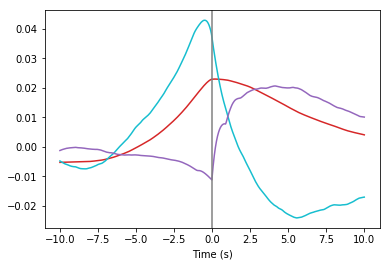

In [7]:
##########
# We now plot the bout triggered cluster responses (Figure 5d)

ts = np.arange(0, 20, dt)-10

pl.plot(ts, bout_triggered_x_avg, "C3")
pl.plot(ts, bout_triggered_y_avg, "C9")
pl.plot(ts, bout_triggered_m_avg*10, "C4")

pl.xlabel("Time (s)")
pl.axvline(0, color='gray')

pl.show()

In [8]:
##########
# Now we perform the simulation for the freely swimming fish

swims_per_second = []
fraction_of_correct_bouts = []
fraction_of_correct_bouts_over_time = []

# We give the simulation more time than the experiment
# to reduce boundary effects
ts = np.arange(0, 80, dt)

# Create the buffers for the simulation
xs_left = np.empty_like(ts)
ys_left = np.empty_like(ts)
zs_left = np.empty_like(ts)
ms_left = np.empty_like(ts)

xs_right = np.empty_like(ts)
ys_right = np.empty_like(ts)
zs_right = np.empty_like(ts)
ms_right = np.empty_like(ts)

bout_times = np.empty(10000)
bout_decisions = np.empty(10000)
        
for coherence in [0, 25, 50, 100]:
    
    swims_per_second_per_coherence = []
    
    correct_swims = 0
    total_swims = 0
    
    correct_swims_over_time = np.zeros(15) # 30 s has 15 2s time bins
    total_swims_over_time = np.zeros(15)
    
    for trial in range(1000):

        # create a constant stimulus vector
        Is_right = np.zeros_like(ts)
        Is_left = np.zeros_like(ts)
        
        ind = np.where((ts > 40) & (ts < 50))
        
        Is_right = np.zeros_like(ts)
        Is_left = np.zeros_like(ts)
        
        Is_left[ind] -= 0.4 * coherence / 100 * 0.2
        Is_right[ind] += coherence / 100 * 0.2

        bout_counter = simulate_network(
            False, False,  # Fish is free, and stimulus keeps going
            ts,
            Is_left, xs_left, ys_left, zs_left, ms_left,
            Is_right, xs_right, ys_right, zs_right, ms_right,
            bout_times, bout_decisions)


        # Only take times after stabilized simulation
        bout_times_trial = bout_times[:bout_counter] - 30
        bout_decisions_trial = bout_decisions[:bout_counter]
        
        # Only take bout_times that are in the right range
        ind_before_after_stimulus = ((bout_times_trial > 0) & 
                                     (bout_times_trial < 30))
        
        bout_times_trial = bout_times_trial[ind_before_after_stimulus]
        bout_decisions_trial = bout_decisions_trial[ind_before_after_stimulus]
        
        
        ind_during_stimulus = np.where((bout_times_trial > 10) & 
                                       (bout_times_trial < 20))
            
        swims_per_second_per_coherence.append(
            len(bout_times_trial[ind_during_stimulus]) / 10.)
        
        for bout_time, bout_decision in zip(bout_times_trial, 
                                            bout_decisions_trial):
            
            total_swims_over_time[int(bout_time / 2)] += 1
            
            if bout_decision == 1:
                correct_swims_over_time[int(bout_time / 2)] += 1
                
        correct_swims += (bout_decisions_trial[ind_during_stimulus] == 1).sum()
        total_swims += len(bout_decisions_trial[ind_during_stimulus])
    
    swims_per_second.append(np.mean(swims_per_second_per_coherence))
    
    fraction_of_correct_bouts.append(100 * correct_swims / total_swims)
    
    correct_swims_over_time = np.array(correct_swims_over_time)
    total_swims_over_time = np.array(total_swims_over_time)
    
    fraction_of_correct_bouts_over_time.append(
        100 * correct_swims_over_time / total_swims_over_time)

fraction_of_correct_bouts_over_time = \
    np.array(fraction_of_correct_bouts_over_time)

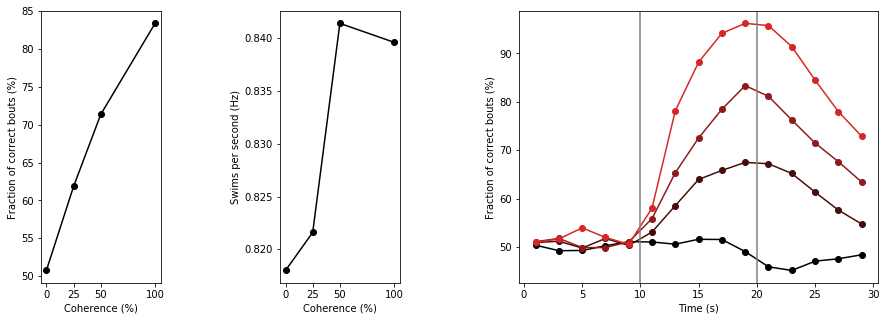

In [9]:
##########
# Plot the behavior, this should reproduce Figure 5e-g

pl.figure(figsize=(15,5))
grid = pl.GridSpec(1, 4, wspace=1, hspace=0.3)

# How does average accuracy on coherence?
pl.subplot(grid[0, 0])
pl.plot([0, 25, 50, 100], fraction_of_correct_bouts, '-o', color='k')
pl.xticks([0, 25, 50, 100])
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Fraction of correct bouts (%)")

# How does swims per second depend on coherence?
pl.subplot(grid[0, 1])
pl.plot([0, 25, 50, 100], swims_per_second, '-o', color='k')
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Swims per second (Hz)")

# The accuracy evolution over time
pl.subplot(grid[0, 2:])
hsv_color = colors.rgb_to_hsv(colors.to_rgb("C3"))
for stim in range(4):
    
    color_saturated = colors.hsv_to_rgb([hsv_color[0], 
                                         hsv_color[1] , 
                                         hsv_color[2] * stim / 3])
        
    pl.plot(np.arange(0, 30, 2) + 1, 
            fraction_of_correct_bouts_over_time[stim], '-o', 
            color = color_saturated)
    
pl.axvline(10, color='gray')
pl.axvline(20, color='gray')
pl.xlabel("Time (s)")
pl.ylabel("Fraction of correct bouts (%)")

pl.show()